# Cross-validation and hyperparameter tuning for decision trees

We have now found that a decision tree, inspired by the iMeta algorithm, gives good results with the XBT dataset. This uses the same input features as iMeta, but with the decision thresholds learnt by standard ML algorithms, rather than chosen based on human analysis. To be confident in using it in assign probe model and menufacturer labels to unlabelled profiles in the dataset, we need to check the robustness of results and how well they generalise. Some particular questions include:
* what are the best hyperparameters for the tree e.g. max depth
* what are the best input features
* how consistent are the results with different train/test splits
* how well do results generalise to cruises not in the training set. This is vital as the  majority of unlabelled profiles come from cruises where none of the profiles are labelled.
(TODO: add a section to data exploration which analyses how many unlabelled profiles come from cruises with no labels.)

### Set up tools
Start by importing libraries and specifying the parameters for the experiment.

In [1]:
import os
import sys
from pathlib import Path
import functools

import pandas
import numpy

import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ipywidgets
import time

In [3]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics

In [4]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [5]:
import xbt_dataset
from xbt_dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter, check_value_found

In [6]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [7]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_with_imeta',
    'pangeo': '/data/misc/xbt-data/csv_with_imeta/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}
output_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_output',
    'pangeo': '/data/misc/xbt-data/csv_output/',

}
result_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/results',
    'pangeo': '/data/misc/xbt-data/results/',
}


In [8]:
output_dir = output_dirs[environment]
output_fname_template = 'xbt_output_{classifier}_{suffix}.csv'
result_dir = result_dirs[environment]
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'
year_range = env_date_ranges[environment]

In [9]:
input_feature_names = ['country','max_depth', 'year']
target_feature = 'instrument'
splitter_features = ['year', 'instrument']
unseen_feature = 'cruise_number'
num_unseen_splits = 5
unseen_fraction = 1.0 / num_unseen_splits
num_train_splits = 5
train_fraction = 1.0 - (1.0 / num_train_splits)
unseen_fold_name = 'unseen_fold'

In [10]:
classifier_class = sklearn.tree.DecisionTreeClassifier
classifier_opts = {}
classifier_name = 'decision_tree_cv'
suffix='country'
classifier_param_grid = {
    'max_depth': [None, 1,5,10,20], 
    'min_samples_leaf': [1,2,5], 
    'criterion': ['gini', 'entropy']
},
cv_metrics = ['recall_micro', 'precision_micro', 'f1_micro']
hp_tune_metric = 'recall_micro'

## Running the cross validation experiment

There are multiple levels to the experiment we want to run. The first to train on part of the data and then test on another part. We want to divide up the profiles by cruise, so the test data consists of cruises that were not seen in the training data. We then want to train a model for each of the possible train/test splits. We divide the model into "folds", and then each splits uses data in fold n as the test set and ther rest as the train, as is standard in machine learning. In this case calculate the fold labels manually rather than using standard functions so we can divide based on cruise number and assign profiles to a fold based on which cruise they come from.

For the training on eeach split, we also then want to use the best hyperparameters. So for each split we run a hyperparameter tuning scheme, ion this case a grid search through the request values of the hyper parameters. The hyper parameters used here are:
* max depth (of the decision tree, not the temperature probe in this case!!)
* min_samples_leaf -  a parameter controlling how frequently a leaf node splits. Lower numbers redces over-fitting tendencies
* citerion - different criteria for scoring predictions while training.

The bottom level is that for each split and set of hyperparameters, we also want to run cross valdation within that training set, to check we have robust results. So we haveter and inner cross validation run together with hper parameter tuning to ensure we have robust results that are as good as we can get, and that demonstrate how well the trainined algorithm will generalise to the unlabelled data.


More information on the approach taken here and the spceific classes and function used can found in the following links:

scikit-learn API documentation:
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

discussion of cross-validationand hyperparameters for decision trees:
* https://scikit-learn.org/stable/modules/cross_validation.html
* https://stackoverflow.com/questions/60996995/use-groupkfold-in-nested-cross-validation-using-sklearn
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
* https://scikit-learn.org/stable/modules/tree.html


In [11]:
%%time
xbt_full_dataset = XbtDataset(env_data_dirs[environment], env_date_ranges[environment])

CPU times: user 2min 3s, sys: 9.89 s, total: 2min 12s
Wall time: 2min 24s


In [12]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 774 ms, sys: 28 ms, total: 802 ms
Wall time: 800 ms


In [13]:
_ = xbt_labelled.get_ml_dataset(return_data=False)

In [14]:
_ = xbt_labelled.filter_features(['instrument','model','manufacturer']).encode_target(return_data = False)

In [15]:
%%time
xbt_labelled.generate_folds_by_feature('cruise_number', num_unseen_splits, unseen_fold_name)

CPU times: user 37.4 s, sys: 59.6 ms, total: 37.5 s
Wall time: 37.5 s


In [16]:
X_labelled = xbt_labelled.filter_features(input_feature_names).get_ml_dataset()[0]
y_labelled = xbt_labelled.filter_features([target_feature]).get_ml_dataset()[0]


In [17]:
group_cv1 = sklearn.model_selection.GroupKFold(n_splits=num_unseen_splits)

In [18]:

clf_dt1 = classifier_class(**classifier_opts)
clf_gridcv1 = sklearn.model_selection.GridSearchCV(clf_dt1,
                                                   param_grid = classifier_param_grid,                                          
                                                   scoring=hp_tune_metric,
                                                   cv=num_train_splits,
                                                  )

In [19]:
%%time
scores = sklearn.model_selection.cross_validate(
    clf_gridcv1,
    X_labelled, y_labelled, 
    groups=xbt_labelled[unseen_fold_name], 
    cv=group_cv1,
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metrics,
    n_jobs=-1,
)

CPU times: user 408 ms, sys: 653 ms, total: 1.06 s
Wall time: 16min 39s


## Plotting results of cross-validation and hyperparameter tuning
In this section we will take a look at the results from the cross validation and hyperparameter tuning of the decision tree to the XBT labelled data. To gain greater understanding, we seprately score the train and test sets for each year of the data and each class of instrument label. This is calculated separately for eeach of the estimators trained for the outer cross-validation (based on cruise numbers). We calculate the recall, precision and f1 metrics both for each class and averaged over all classes.

In [20]:
def generate_metrics(clf, xbt_ds, data_label, target_feature, input_feature_names, year_range):
    metric_list = []
    for year in range(year_range[0],year_range[1]):
        X_year = xbt_ds.filter_obs({'year': year}, ).filter_features(input_feature_names).get_ml_dataset()[0]
        y_year = xbt_ds.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]

        y_res_year = clf.predict(X_year)
        cats = list(xbt_ds._feature_encoders[target_feature].classes_)
        prec_year, recall_year, f1_year, support_year = sklearn.metrics.precision_recall_fscore_support(
            y_year, y_res_year, average='micro', labels=range(0,len(cats)))
        prec_cat, recall_cat, f1_cat, support_cat = sklearn.metrics.precision_recall_fscore_support(
            y_year, y_res_year, labels=range(0,len(cats)))

        column_template = '{metric}_{data}_{subset}'
        metric_dict = {'year': year,
                       column_template.format(data=data_label, metric='precision', subset='all'): prec_year,
                       column_template.format(data=data_label, metric='recall', subset='all'): recall_year,
                       column_template.format(data=data_label, metric='f1', subset='all'): f1_year,
                      }

        metric_dict.update({column_template.format(data=data_label, metric='precision', subset=cat): val for cat, val in zip(cats, prec_cat)})
        metric_dict.update({column_template.format(data=data_label, metric='recall', subset=cat): val for cat, val in zip(cats, recall_cat)})
        metric_dict.update({column_template.format(data=data_label, metric='f1', subset=cat): val for cat, val in zip(cats, f1_cat)})
        metric_dict.update({column_template.format(data=data_label, metric='support', subset=cat): val for cat, val in zip(cats, support_cat)})
        metric_list += [metric_dict]

    metrics_df = pandas.DataFrame.from_records(metric_list)
    return metrics_df 

In [21]:
%%time
metrics_list = {}
for split_num, estimator in enumerate(scores['estimator']):
    xbt_train = xbt_labelled.filter_obs({unseen_fold_name: split_num}, mode='exclude')
    xbt_test = xbt_labelled.filter_obs({unseen_fold_name: split_num}, mode='include')
    train_metrics = generate_metrics(estimator, xbt_train, 'train_{0}'.format(split_num), target_feature, input_feature_names, year_range )
    test_metrics = generate_metrics(estimator, xbt_test, 'test_{0}'.format(split_num), target_feature, input_feature_names, year_range)
    metrics_list[split_num] = pandas.merge(train_metrics, test_metrics, on='year')


CPU times: user 40.6 s, sys: 9.67 s, total: 50.3 s
Wall time: 50.3 s


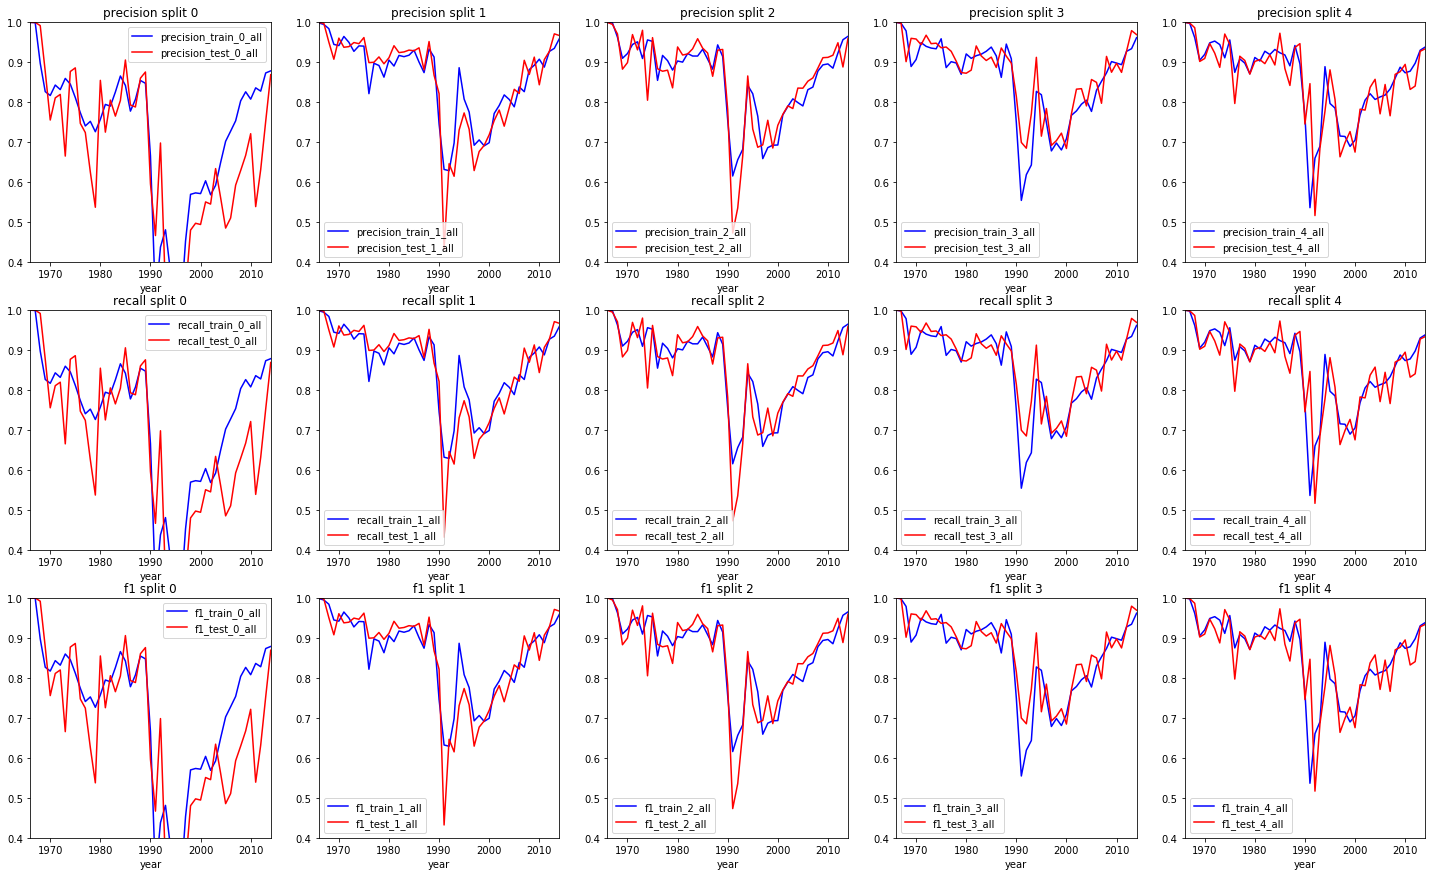

In [22]:
fig_results = matplotlib.pyplot.figure('xbt_results',figsize=(25,15))
for label1, metrics1  in metrics_list.items():
    ax_precision = fig_results.add_subplot(3,5,label1 +1, title='precision split {0}'.format(label1))
    ax_recall = fig_results.add_subplot(3,5,label1 + 1 + 5 * 1, title='recall split {0}'.format(label1))
    ax_f1 = fig_results.add_subplot(3,5,label1 + 1 + 5 * 2, title='f1 split {0}'.format(label1))
    metrics1.plot.line(ax=ax_precision, x='year', y=[f'precision_train_{label1}_all',f'precision_test_{label1}_all'], color=['b', 'r'], ylim=(0.4,1.0))
    metrics1.plot.line(ax=ax_recall, x='year', y=[f'recall_train_{label1}_all',f'recall_test_{label1}_all'], color=['b', 'r'], ylim=(0.4,1.0))
    metrics1.plot.line(ax=ax_f1, x='year', y=[f'f1_train_{label1}_all',f'f1_test_{label1}_all'], color=['b', 'r'], ylim=(0.4,1.0))

    
    

Also of interest is what hyper parameters were chosen by the GridCV hyperparameter tuning process. The following listing shows which parameters result in the best results for each split. We see that limiting the number of nodes resulted in better performance and restricting how nodes could split (min_samples_leaf) also varied based o the split. Varying these parameters results in different classifications so we get some profiles with different class assignments between different classifiers.

In [23]:
[est1.best_params_ for est1 in scores['estimator']]

[{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}]

In [24]:
metrics_df_merge = None
for label1, metrics1  in metrics_list.items():
    if metrics_df_merge is None:
        metrics_df_merge = metrics1
    else:
        metrics_df_merge = pandas.merge(metrics_df_merge, metrics1)

In [25]:
results_output_path = os.path.join(result_dir,
                                   result_fname_template.format(classifier=classifier_name, 
                                                                suffix=suffix))
metrics_df_merge.to_csv(results_output_path)

### Outputing the data

To filter based on what profiles we can use for predicting, we need some way of checking each profile we create these checkers from the labelled dataset, because the subset of data that was used for training determines what subset is valid for prediction. For example, if a country is not present in the training data, then the prediction function won't be able to handle that profile to predict a probe model and manufacturer. Profiles that are not handled by the trained classifier will get the label "UNKNOWN".


In [26]:
# checker functions check each element of the profile metadata that could be a problem. The checkers are constructed from the labelled data subset.
checkers_labelled = {f1: c1 for f1, c1 in xbt_labelled.get_checkers().items() if f1 in input_feature_names}

In [27]:
result_feature_template = 'instrument_res_dt_split{split_num}'

In [28]:
%%time
xbt_predictable = xbt_full_dataset.filter_predictable(checkers_labelled)

CPU times: user 4min 1s, sys: 683 ms, total: 4min 2s
Wall time: 4min 2s


In [29]:
%%time
result_feature_names = []
# classifications_df = None
for split_num, estimator in enumerate(scores['estimator']):
    res_name = result_feature_template.format(split_num=split_num)
    result_feature_names += [res_name]
    res_ml1 = estimator.predict(xbt_predictable.filter_features(input_feature_names).get_ml_dataset()[0])
    res2 = list(xbt_labelled._feature_encoders['instrument'].inverse_transform(res_ml1).reshape(-1))
    xbt_predictable.xbt_df[res_name] = res2


CPU times: user 8.5 s, sys: 3.32 s, total: 11.8 s
Wall time: 11.8 s


In [30]:
def imeta_instrument(row1):
    return 'XBT: {t1[0]} ({t1[1]})'.format(t1=imeta_classification(row1))

In [31]:
%%time
imeta_output_flags = []
for res_name in result_feature_names:
    flag_name = f'imeta_applied_{res_name}'
    imeta_output_flags += [flag_name]
    xbt_predictable.xbt_df[flag_name] = 0
    xbt_predictable.xbt_df.loc[xbt_predictable.xbt_df[xbt_predictable.xbt_df[res_name].isnull()].index, flag_name] = 1
    xbt_predictable.xbt_df[flag_name] = xbt_predictable.xbt_df[flag_name].astype('int8')
    xbt_predictable.xbt_df.loc[xbt_predictable.xbt_df[xbt_predictable.xbt_df[res_name].isnull()].index, res_name] = \
        xbt_predictable.xbt_df[xbt_predictable.xbt_df[res_name].isnull()].apply(imeta_instrument, axis=1)



CPU times: user 2.69 s, sys: 389 ms, total: 3.08 s
Wall time: 3.07 s


In [32]:
%%time
fv_dict = {rfn1: UNKNOWN_STR for rfn1 in result_feature_names}
fv_dict.update({f1: 1 for f1 in imeta_output_flags})
xbt_full_dataset.merge_features(xbt_predictable, result_feature_names + imeta_output_flags,
                               fill_values = fv_dict,
                               feature_encoders={rfn1: xbt_labelled._feature_encoders['instrument'] for rfn1 in result_feature_names},
                               target_encoders={rfn1: xbt_labelled._target_encoders['instrument'] for rfn1 in result_feature_names},                                
                                output_formatters={rfn1: cat_output_formatter for rfn1 in result_feature_names})

CPU times: user 2.23 s, sys: 505 ms, total: 2.73 s
Wall time: 2.73 s


In [33]:
%%time
xbt_unknown_inputs = xbt_full_dataset.filter_obs({'classification_quality_flag': 0})
imeta_instrument_fallback = xbt_unknown_inputs.xbt_df.apply(imeta_instrument, axis=1)
for res_name in result_feature_names:
    xbt_full_dataset.xbt_df.loc[xbt_unknown_inputs.xbt_df.index, res_name] = imeta_instrument_fallback

CPU times: user 373 ms, sys: 28.3 ms, total: 401 ms
Wall time: 399 ms


The classifier is unable to predict a class for some of the profiles. This can be either because the classifier cannot produce a result, or because the country is not present in the labelled dataset. In these cases iMeta is used as a fallback. This plot shows for what proportion of profiles this occurs.

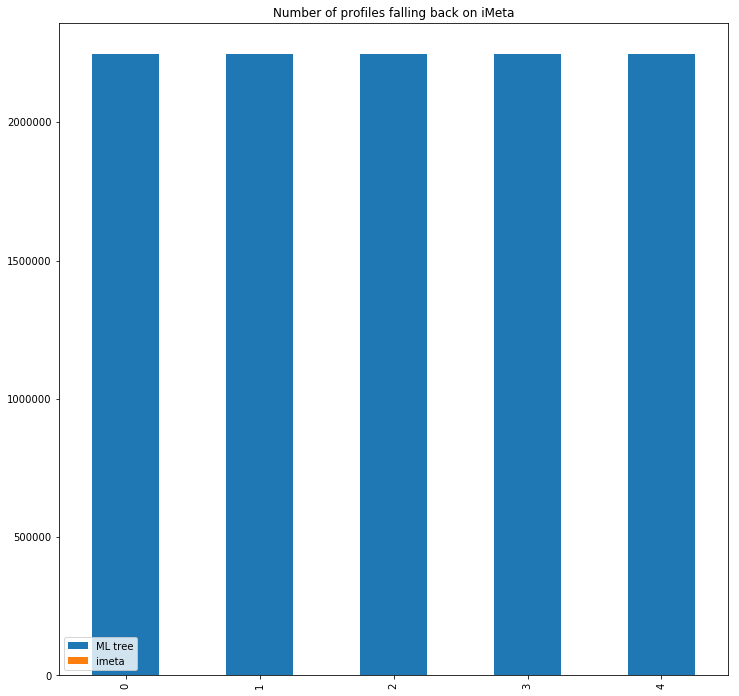

In [34]:
pandas.DataFrame.from_records([dict(zip(['ML tree','imeta'] ,xbt_full_dataset.xbt_df[imf1].value_counts().values)) for imf1 in imeta_output_flags]).plot(kind='bar',stacked=True,title='Number of profiles falling back on iMeta', figsize=(12,12))

Of interest in our classifier ensemble is how many profiles are labelled differently by different classifiers. Here we count the different labels for each profile. We say that the ajority get only 1 label, but a substantial minority get 2 ior 3 labels, and some get as many as 5 (a different classification from each trained instance of the classifier!). For those profile which have been assigned more that one label, we can assign probabilities based on the number of classifiers "voting" for each label. This is not a real probability, but give some idea of the confidence we have in assigned labels. It could also be used as a distribution from which to sample for an esemble temperature dataset.

In [35]:
%%time
count1 = xbt_full_dataset.filter_features(result_feature_names).xbt_df.apply(lambda row1: len(set(row1.values)), axis='columns')

CPU times: user 15.1 s, sys: 126 ms, total: 15.2 s
Wall time: 15.1 s


In [36]:
count1.value_counts()

1    1459415
2     779497
3       5919
4       1926
dtype: int64

In [40]:
%%time
vote_count = numpy.zeros([xbt_full_dataset.shape[0], len(xbt_full_dataset._feature_encoders[result_feature_names[0]].classes_[0])],dtype=numpy.float64)
for res_name in result_feature_names:
    vote_count += xbt_full_dataset.filter_features([res_name]).get_ml_dataset()[0]
    
vote_count /= float(len(result_feature_names))

CPU times: user 2.71 s, sys: 117 ms, total: 2.82 s
Wall time: 2.82 s


In [41]:
%%time
vote_dict = {f'instrument_probability_{cat1}': vote_count[:,ix1] for ix1, cat1 in enumerate(xbt_full_dataset._feature_encoders['instrument'].classes_[0])}
vote_dict.update({'id': xbt_full_dataset['id']})
vote_df = pandas.DataFrame(vote_dict)

CPU times: user 419 ms, sys: 88.4 ms, total: 507 ms
Wall time: 505 ms


In [42]:
xbt_full_dataset.xbt_df = xbt_full_dataset.xbt_df.merge(vote_df, on='id')

In [43]:
%%time
xbt_full_dataset.output_data(os.path.join(output_dir, output_fname_template.format(classifier=classifier_name,
                                                                                  suffix=suffix)),
                             target_features=[])

CPU times: user 1min 35s, sys: 1.62 s, total: 1min 36s
Wall time: 1min 54s


## Summary for ML tree with cross-validation and hyperparameter tuning
 (under construction)